# Welcome and have fun learning multiclass classification with plug and play Neural Network

#### You are dealing with a **heavly skewed** dataset when some classes(1, 2 and 3) are much more frequent than others. **Accuracy** is not the perferred performance measure for multiclass problem in this case. Softvoting and weighted average is the objective to score towards target class 1, 2 and 3.

Objective of this notebook used to be a ~simple~ and robust neural network multiclass classifier for future use.

<blockquote style="margin-right:auto; margin-left:auto; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

**Notes:**
Run time -
4 hours and 31 minutes 4000000 samples
3318.3s 395712 samples
4375.7s 1468136 samples
12905.1s 2262087 samples
5555.3s - GPU 2262087 samples
6941.8s - TPU v3-8 2262087 samples

Version 98: 300, 256, 128, 128 0.1DROP MCDrop
Version 121: AlphaDropout dropped bad performance

## Imports and Configuration ##

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
from scipy import stats
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, PowerTransformer, OneHotEncoder
le = LabelEncoder()
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

from datetime import datetime
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."
import tensorboard
tensorboard.__version__
# Clear any logs from previous runs
!rm -rf ./logs/ 

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import gc
import os
import math
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

TensorFlow version:  2.7.0


'rm' is not recognized as an internal or external command,
operable program or batch file.


## Fine tuning
Fine tune the system using the hyperparameters and configs below:
* FOLD - 5, 10, 15, 20.
* SAMPLE - Set it to True for full sample run. Max sample per class.
* BEST_OR_FOLD - True: use Best model, False: use KFOLD softvote
* TPU - Only works on save version.
* selu love lecun_normal

In [2]:
# -----------------------------------------------------------------
# Some parameters to config 
PRODUCTION = False  # True: For submission run. False: Fast trial run

# Hyperparameters
FOLDS = 21 if PRODUCTION else 2   # Only 5 or 10.
EPOCHS = 121        # Does not matter with Early stopping. Deep network should not take too much epochs to learn
BATCH_SIZE = 2048   # large enough to fit RAM. If unstable, tuned downward. 4096 2048
ACTIVATION = 'selu' # swish mish relu selu ;swish seem to work better with binary classification only?
KERNEL_INIT = "lecun_normal" # Minimal impact, but give your init the right foot forward glorot_uniform
LEARNING_RATE = 0.000965713 # Not used. Optimal lr is about half the maximum lr 
LR_FACTOR = 0.7   # LEARNING_RATE * LR_FACTOR = New Learning rate on ReduceLROnPlateau. lower down when the LR oscillate
MIN_DELTA = 0.0000001 # Default 0.0001 0.0000001
RLRP_PATIENCE = 5 # Learning Rate reduction on ReduceLROnPlateau
ES_PATIENCE = 19  # Early stopping
DROPOUT = 0.1     # Act like L1 L2 regulator. lower your learning rate in order to overcome the "boost" that the dropout probability gives to the learning rate.
HIDDEN_LAYERS = [192, 128, 128, 64]

OPTIMIZER = 'adam' # adam adamax nadam
LOSS ='sparse_categorical_crossentropy' # sparse_categorical_crossentropy does not require onehot encoding on labels. categorical_crossentropy
METRICS ='accuracy'  # acc accuracy categorical_accuracy sparse_categorical_accuracy
ACC_VAL_METRICS = 'val_accuracy' # 'val_acc' val_accuracy val_sparse_categorical_accuracy
ACC_METRICS = 'accuracy' # acc accuracy 'sparse_categorical_accuracy'

# The dataset is too huge for trial. Sampling it for speed run!
SAMPLE = 2262087 if PRODUCTION else 11426   # True for FULL run. Max Sample size per category. For quick test: y counts [1468136, 2262087, 195712, 377, 1, 11426, 62261]  # 4000000 total rows
VALIDATION_SPLIT = 0.15 # Only used to min dataset for quick test
MAX_TRIAL = 3           # speed trial any% Not used here
MI_THRESHOLD = 0.001    # Mutual Information threshold value to drop.

RANDOM_STATE = 42
VERBOSE = 0

# Admin
ID = "Id"            # Id id x X index
INPUT = "../input/tabular-playground-series-dec-2021"
TPU = False           # True: use TPU.
BEST_OR_FOLD = False # True: use Best model, False: use KFOLD softvote
FEATURE_ENGINEERING = True
PSEUDO_LABEL = True

assert BATCH_SIZE % 2 == 0, \
    "BATCH_SIZE must be even number."

## Data Preprocessing ##

Before we can do any feature engineering, we need to *preprocess* the data to get it in a form suitable for analysis. We'll need to:
- **Load** the data from CSV files
- **Clean** the data to fix any errors or inconsistencies
- **Encode** the statistical data type (numeric, categorical)
- **Impute** any missing values

We'll wrap all these steps up in a function, which will make easy for you to get a fresh dataframe whenever you need. After reading the CSV file, we'll apply three preprocessing steps, `clean`, `encode`, and `impute`, and then create the data splits: one (`df_train`) for training the model, and one (`df_test`) for making the predictions that you'll submit to the competition for scoring on the leaderboard.

### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [3]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## Reduce Memory usage

In [4]:
# for col in df.select_dtypes('int').columns:
#     df[col] = pd.to_numeric(df[col], downcast = 'integer')

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
 
    return df

# Feature Engineering
These features are borrowed from https://www.kaggle.com/gulshanmishra/tps-dec-21-tensorflow-nn-feature-engineering
Do read dataset description from https://www.kaggle.com/c/forest-cover-type-prediction/data
The log transform is a powerful tool for dealing with positive numbers with a heavy-
tailed  distribution.  (A  heavy-tailed  distribution  places  more  probability  mass  in  the
tail range than a Gaussian distribution.) It compresses the long tail in the high end of
the  distribution  into  a  shorter  tail,  and  expands  the  low  end  into  a  longer  head.

In [5]:
from category_encoders import MEstimateEncoder
# extra feature engineering
def r(x):
    if x + 180 > 360:
        return x - 180
    else:
        return x + 180

def feature_engineer(df):
    # Distance features
    # Euclidean distance to Hydrology
    df["ecldn_dist_hydrlgy"] = (df["Horizontal_Distance_To_Hydrology"]**2 + df["Vertical_Distance_To_Hydrology"]**2)**0.5
    # Manhhattan distance to Hydrology
    df["mnhttn_dist_hydrlgy"] = np.abs(df["Horizontal_Distance_To_Hydrology"]) + np.abs(df["Vertical_Distance_To_Hydrology"])
    df["fire_road"] = np.abs(df["Horizontal_Distance_To_Fire_Points"]) + np.abs(df["Horizontal_Distance_To_Roadways"])
    df["fire_water"] = np.abs(df["Horizontal_Distance_To_Fire_Points"]) + np.abs(df["Horizontal_Distance_To_Hydrology"])
    df["road_water"] = np.abs(df["Horizontal_Distance_To_Roadways"]) + np.abs(df["Horizontal_Distance_To_Hydrology"])
    # code to replace all negative value with 0 and Log transform
    # df['Horizontal_Distance_To_Roadways'][df['Horizontal_Distance_To_Roadways'] < 0] = 0
    # df['horizontal_Distance_To_Roadways_Log'] = [math.log(v+1) for v in df['Horizontal_Distance_To_Roadways']]
    # df['Horizontal_Distance_To_Fire_Points'][df['Horizontal_Distance_To_Fire_Points'] < 0] = 0
    # df['horizontal_Distance_To_Fire_Points_Log'] = [math.log(v+1) for v in df['Horizontal_Distance_To_Fire_Points']]
    
    # Elevation features
    df['hydro_elevationecldn'] = df['Elevation'] + df['ecldn_dist_hydrlgy'] # ecldn_dist_hydrlgy
    df['hydro_elevationmnhttn'] = df['Elevation'] + df['mnhttn_dist_hydrlgy'] # ecldn_dist_hydrlgy
    df['hydro_elevation'] = df['Elevation'] - df['Vertical_Distance_To_Hydrology'] # ecldn_dist_hydrlgy
#     df['binned_elevation'] = [math.floor(v/50.0) for v in df['Elevation']]
    df['highwater'] = (df.Vertical_Distance_To_Hydrology < 0).astype(int)
    # df['eHDtH'] = df.Elevation - df.Horizontal_Distance_To_Hydrology * 0.2
    
    # Aspect features, hardest FE
    df.loc[df["Aspect"] < 0, "Aspect"] += 360
    df.loc[df["Aspect"] > 359, "Aspect"] -= 360
    df['binned_aspect'] = [math.floor((v+60)/45.0) for v in df['Aspect']]
    df['binned_aspect2'] = [math.floor((v+180)/30.0) for v in df['Aspect']]
    df['aspectXslope'] = df['Aspect'] * df['Slope'] # aspect x slope
#     df['aspectbinXslope'] = df['binned_aspect'] * df['Slope'] # aspect x slope
    df['aspect2'] = df.Aspect.map(r)
    # Transform Cyclic Ordinal attributes to X y coordinates. 0 degree will be group with 359 degree etc.
    # df['aspectX'] = np.sin(2.*np.pi*df.Aspect/360)
    # df['aspecty'] = np.cos(2.*np.pi*df.Aspect/360)
#     df['aspectXXslope'] = df['aspectX'] * df['Slope'] # aspect x slope
#     df['aspectyXslope'] = df['aspecty'] * df['Slope'] # aspect x slope

    # Soil and wilderness features
    soil_features = [x for x in df.columns if x.startswith("Soil_Type")]
    df["soil_type_count"] = df[soil_features].sum(axis=1)
    wilderness_features = [x for x in df.columns if x.startswith("Wilderness_Area")]
    df["wilderness_area_count"] = df[wilderness_features].sum(axis = 1)
    df['soil_Type12_32'] = df['Soil_Type32'] + df['Soil_Type12']
    df['soil_Type23_22_32_33'] = df['Soil_Type23'] + df['Soil_Type22'] + df['Soil_Type32'] + df['Soil_Type33']

    # Hillshade features
    features_Hillshade = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
#     df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] += 360
#     df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] += 360
#     df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] += 360
#     df['Hillshade_9am_AspectX'] = np.sin(2.*np.pi*df.Hillshade_9am/360)
#     df['Hillshade_9am_Aspecty'] = np.cos(2.*np.pi*df.Hillshade_9am/360)
#     df['Hillshade_Noon_AspectX'] = np.sin(2.*np.pi*df.Hillshade_Noon/360)
#     df['Hillshade_Noon_Aspecty'] = np.cos(2.*np.pi*df.Hillshade_Noon/360)
#     df['Hillshade_3pm_AspectX'] = np.sin(2.*np.pi*df.Hillshade_3pm/255)
#     df['Hillshade_3pm_Aspecty'] = np.cos(2.*np.pi*df.Hillshade_3pm/255)
    df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
    df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
    df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
    df.loc[df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
    df.loc[df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
    df.loc[df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
    df['Hillshade_Noon_is_bright'] = (df.Hillshade_Noon == 255).astype(int)
    df['Hillshade_9am_is_zero'] = (df.Hillshade_9am == 0).astype(int)
    df['hillshade_3pm_is_zero'] = (df.Hillshade_3pm == 0).astype(int)
    # df["hillshade_mean"] = df[features_Hillshade].mean(axis = 1)
    # df['hillshade_amp'] = df[features_Hillshade].max(axis = 1) - df[features_Hillshade].min(axis = 1)
    
    # df.drop(["Aspect"]+features_Hillshade, axis=1, inplace=True)
    
    return df

In [6]:
from pathlib import Path
def load_data():
    # Read data
    data_dir = Path(INPUT)
    df_train = pd.read_csv(data_dir / "train.csv", index_col=ID)
    df_test = pd.read_csv(data_dir / "test.csv", index_col=ID)
    
    if PSEUDO_LABEL:
        df_pseudolabels = pd.read_csv("../input/tps12-pseudolabels/tps12-pseudolabels_v2.csv", index_col=ID)
        df_train = pd.concat([df_train, df_pseudolabels], axis=0) # You can't beat them, you join them for new baseline
        df_train.reset_index(drop=True)

    # Merge the splits so we can process them together
#     df = pd.concat([df_train, df_test])
    # Preprocessing
#     df = clean(df)
#     df = encode(df)
    df_train = impute(df_train)
    df_test = impute(df_test)
    
    if FEATURE_ENGINEERING:
        df_train = feature_engineer(df_train)
        df_test = feature_engineer(df_test)
        
    df_train = reduce_mem_usage(df_train)
    df_test = reduce_mem_usage(df_test)
    
    # Reform splits
#     df_train = df.loc[df_train.index, :]
#     df_test = df.loc[df_test.index, :]
    return df_train, df_test

# Load Data #

And now we can call the data loader and get the processed data splits:

In [7]:
%%time
train_data, test_data = load_data()

Mem. usage decreased to 503.90 Mb (82.1% reduction)
Mem. usage decreased to 100.14 Mb (82.0% reduction)
Wall time: 50.7 s


In [8]:
column_y = train_data.columns.difference(test_data.columns)[0] # column_y target_col label_col

In [9]:
# customized XY TBR
# idx = train_data[train_data[column_y] == 4].index
# train_data.drop(idx, axis = 0, inplace = True)
idx = train_data[train_data[column_y] == 5].index
train_data.drop(idx, axis = 0, inplace = True)
# idx = train_data[train_data[column_y] == 6].index # Less then 0.5% significant different, dropped
# train_data.drop(idx, axis = 0, inplace = True)

cols = ["Soil_Type7", "Soil_Type15"]
train_data.drop(cols, axis = 1, inplace= True)
test_data.drop(cols, axis = 1, inplace = True)

y to categorical

In [10]:
X = train_data.drop(columns=column_y)
y = train_data[[column_y]]

X_test = test_data.iloc[:,:]

gc.collect()

22

In [11]:
# Check NA
missing_val = X.isnull().sum()
print(missing_val[missing_val > 0])

Series([], dtype: int64)


# Undersampling
For experiment measurements

## For quick test
TomekLinks
(array([1, 2, 3, 4, 5, 6, 7]),
 array([1390684, 2169226,  155218,     218,       1,    7627,   38757]))

In [12]:
# Uncomment to peek at samples across all targets.
small_sampling = train_data.groupby(column_y).apply(lambda s: s.sample(min(len(s), 960000)))

In [13]:
from sklearn.feature_selection import mutual_info_regression
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=RANDOM_STATE)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.rcParams["figure.figsize"] = (15,12)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [14]:
def drop_uninformative(df, mi_scores, threshold = 0.001):
    return df.loc[:, mi_scores > threshold]

In [15]:
def plot_features(features, df):
    for feature in features:
        plt.rcParams["figure.figsize"] = (15,9)
        for ctype in list(df[column_y].unique()):
            values = df.loc[df[column_y] == ctype][feature].values
            sns.scatterplot(x=values, y=np.arange(values.size), label=f"{column_y} {ctype}", alpha=0.35, palette="deep")
        plt.title(feature)
        plt.legend()
        plt.show()

# Basic EDA
Scatter plots for features with continuous values.

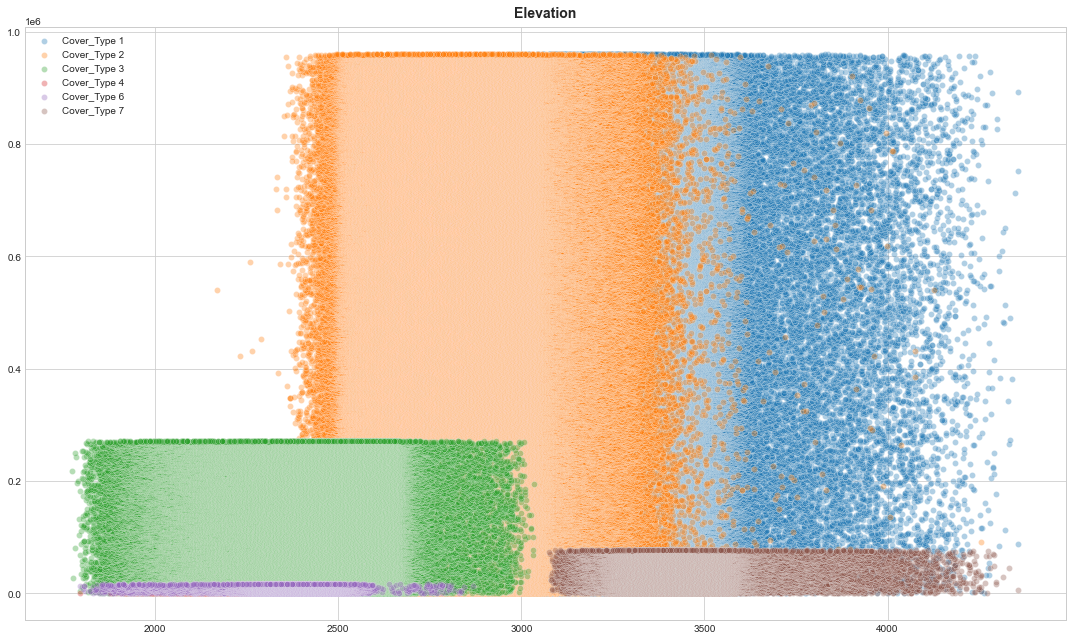

C:\Users\furyx\miniconda3\envs\tf27\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


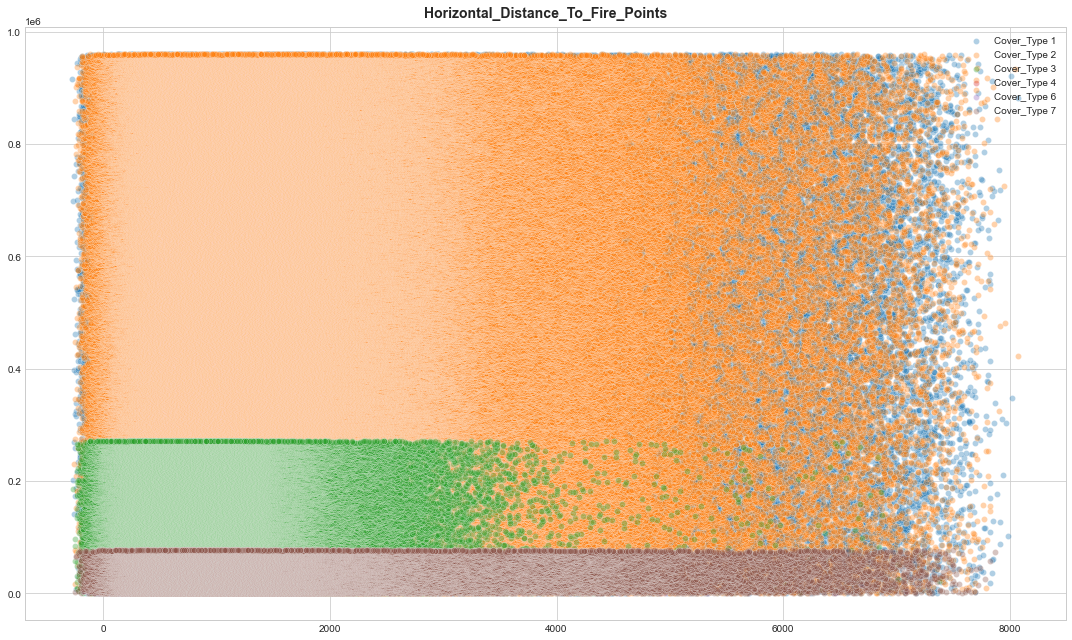

In [16]:
# Scatter plots for features with continuous values , 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'horizontal_Distance_To_Fire_Points_Log', 'hillshade_mean', 'hillshade_amp']
features_cols = ['Elevation',
#                  'eHDtH',
#                  'Soil_Type10',
#                  'soil_type_count',
#                  'Wilderness_Area4',
                 'Horizontal_Distance_To_Fire_Points',
#                  'aspectXslope'
                ]

plot_features(features=features_cols,df=small_sampling)

## Feature Utility Scores

Use mutual information to compute a utility score for a feature, giving you an indication of how much potential the feature has. This hidden cell defines the two utility functions we used, make_mi_scores and plot_mi_scores:

In [17]:
# # Choose a set of features to encode and a value for m
# encoder = MEstimateEncoder(
#     cols=["binned_aspect"],
#     m=1.0,
# )
# # Encode the training split
# small_sampling = encoder.fit_transform(small_sampling, small_sampling[column_y])

## Group by labels, how many predictors are obvious?

In [18]:
train_data.groupby(column_y).apply(lambda s: s.sample(min(len(s), 5)))

Elevation  Aspect  Slope  \
Cover_Type Id                                  
1          3993659       3084     225      5   
           4335067       3359     308     16   
           4476843       3373     206      0   
           3081476       3073      57      7   
           4012785       3255      20     28   
2          3043815       2614     136     20   
           2777248       2964       5     30   
           3145662       2643      76     10   
           4373670       2963      67     30   
           1958079       2847     106     31   
3          4662910       2455     112      9   
           127403        1989      60     31   
           4349016       2523      76     24   
           2647578       2525     156     12   
           2927595       2512      34     14   
4          636550        2032      72     14   
           3125138       2327     317     12   
           3401525       2323     219      7   
           3637490       2183     344     18   
           3054577       2078      88      9   
6          2943844       2436     318     25   
           3769654       2365      91     19   
           4985581       2440     219     20   
           2457334       2460      50     30   
           3526551       2464     123     10   
7          4528922       3429     176     32   
           2754488       3319      74     36   
           1541319       3354      52     22   
           2531426       3890      62     23   
           4239801       3429     118     21   

                    Horizontal_Distance_To_Hydrology  \
Cover_Type Id                                          
1          3993659                                43   
           4335067                               232   
           4476843                               326   
           3081476                               280   
           4012785                                61   
2          3043815                               191   
           2777248                              1146   
           3145662                               148   
           4373670                               388   
           1958079                               176   
3          4662910                               250   
           127403                                 36   
           4349016                               453   
           2647578                               497   
           2927595                               111   
4          636550                                  0   
           3125138                                11   
           3401525                                -2   
           3637490                                96   
           3054577                               258   
6          2943844                                36   
           3769654                               388   
           4985581                               394   
           2457334                               259   
           3526551                               113   
7          4528922                               215   
           2754488                                67   
           1541319                               442   
           2531426                                30   
           4239801                               290   

                    Vertical_Distance_To_Hydrology  \
Cover_Type Id                                        
1          3993659                              -2   
           4335067                             125   
           4476843                              13   
           3081476                              87   
           4012785                              56   
2          3043815                              -7   
           2777248                               6   
           3145662                               5   
           4373670                              24   
           1958079                             115   
3          4662910                        

In [19]:
%%time
mi_scores = make_mi_scores(small_sampling, small_sampling[column_y])

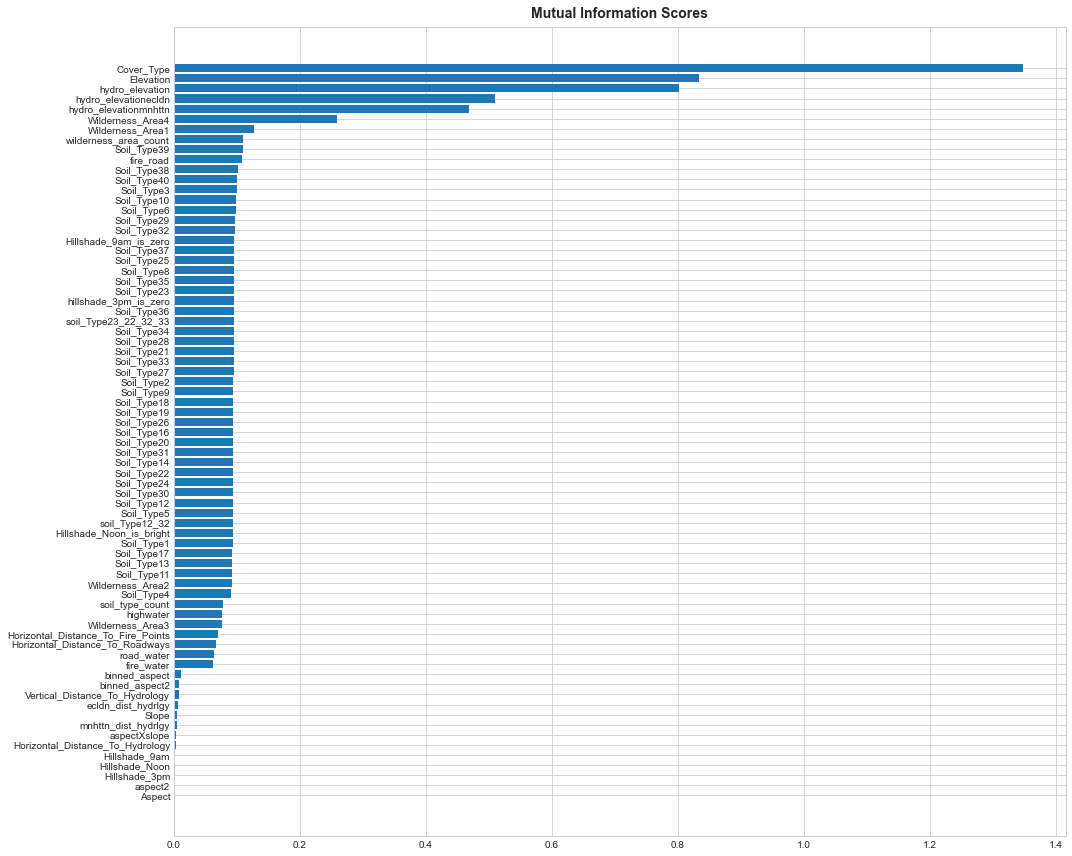

In [ ]:
plot_mi_scores(mi_scores)

### Top10 predictors

In [ ]:
mi_scores[:10]

Cover_Type               1.347573
Elevation                0.833988
hydro_elevation          0.801301
hydro_elevationecldn     0.509006
hydro_elevationmnhttn    0.468916
Wilderness_Area4         0.258484
Wilderness_Area1         0.127024
wilderness_area_count    0.109701
Soil_Type39              0.109351
fire_road                0.109133
Name: MI Scores, dtype: float64

### Worst 10 predictors

In [ ]:
mi_scores[-10:]

ecldn_dist_hydrlgy                  0.006302
Slope                               0.005008
mnhttn_dist_hydrlgy                 0.004660
aspectXslope                        0.004263
Horizontal_Distance_To_Hydrology    0.003856
Hillshade_9am                       0.002373
Hillshade_Noon                      0.001619
Hillshade_3pm                       0.001053
aspect2                             0.000544
Aspect                              0.000544
Name: MI Scores, dtype: float64

In [24]:
def sampling_size_params(labels, sampling_max_size = SAMPLE):
    ''' Return sampling parameters {labels: sample_size}'''
    sampling_key, sampling_count = np.unique(labels, return_counts=True)
    sampling_count[sampling_count > sampling_max_size] = sampling_max_size
    zip_iterator = zip(sampling_key, sampling_count)
    return dict(zip_iterator)

Undersample if SAMPLE parameter < actual count.

In [25]:
# not minority
sampling_params = sampling_size_params(y, SAMPLE)
undersample = RandomUnderSampler(
    sampling_strategy=sampling_params, random_state=RANDOM_STATE)

X, y = undersample.fit_resample(X, y)

Drop features with 0 MI

In [26]:
X = drop_uninformative(X, mi_scores, MI_THRESHOLD)
X_test = drop_uninformative(X_test, mi_scores, MI_THRESHOLD)

In [27]:
soil_features = [x for x in X.columns if x.startswith("Soil_Type")]
wilderness_features = [x for x in X.columns if x.startswith("Wilderness_Area")]
binary_features = soil_features + wilderness_features

In [28]:
transform_cols = X.columns[~X.columns.isin(binary_features)] # Numeric features

In [29]:
# Prepare for multiclass classification tf.keras.utils.to_categorical(le.fit_transform(y[column_y])) categorical_crossentropy
y_cat = le.fit_transform(y[column_y]) # y to categorical

In [30]:
np.unique(y, return_counts=True)

(array([1, 2, 3, 4, 6, 7], dtype=int8),
 array([11426, 11426, 11426,   379, 11426, 11426], dtype=int64))

In [31]:
del mi_scores
del small_sampling
gc.collect()

25645

In [32]:
CSV_HEADER = list(train_data.columns[:])

TARGET_FEATURE_NAME = column_y

TARGET_FEATURE_LABELS = np.unique(y_cat)

NUMERIC_FEATURE_NAMES = list(X.columns[:])

CATEGORICAL_FEATURES_WITH_VOCABULARY = {}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

INPUT_SHAPE = X.shape[-1]
OUTPUT_SHAPE = le.classes_.shape[-1]

In [33]:
print(CSV_HEADER)
print(INPUT_SHAPE)
print(OUTPUT_SHAPE)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type', 'ecldn_dist_hydrlgy', 'mnhttn_dist_hydrlgy', 'fire_road', 'fire_water', 'road_water', 'hydro_elevationecldn', 'hydro

# Scaler transformer
By using RobustScaler(), we can remove the outliers
![](https://github.com/furyhawk/kaggle_practice/blob/main/images/Scalers.png?raw=true)

In [34]:
transformer_cat_cols = make_pipeline(
    SimpleImputer(),
)
transformer_num_cols = make_pipeline(
    RobustScaler(),
#     StandardScaler(),
#     MinMaxScaler(feature_range=(0, 1))
)

preprocessor = make_column_transformer(
    (transformer_num_cols, transform_cols), # X.columns[:] transform_cols remainder = 'passthrough'
    ('passthrough', binary_features)
)

# Train Model and Create Submissions #

Once you're satisfied with everything, it's time to create your final predictions! This cell will:
- use the best trained model to make predictions from the test set
- save the predictions to a CSV file

$Softmax: \sigma(z_i) = \frac{e^{z_{i}}}{\sum_{j=1}^K e^{z_{j}}} \ \ \ for\ i=1,2,\dots,K$

K - number of classes

$z_i$ - is a vector containing the scores of each class for the instance z.

$\sigma(z_i)$ - is the estimated probability that the instance z belongs to class K, given the scores of each class for that instance.

$Relu(z) = max(0, z)$

Binary Cross Entropy: $-{(y\log(p) + (1 - y)\log(1 - p))}$

For multiclass classification, we calculate a separate loss for each class label per observation and sum the result.

$-\sum_{c=1}^My_{o,c}\log(p_{o,c})$


    M - number of classes

    log - the natural log

    y - binary indicator (0 or 1) if class label c is the correct classification for observation o

    p - predicted probability observation o is of class c



## Create Models

In [35]:
modelCheckpoint = None

if TPU:
    save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
    modelCheckpoint = ModelCheckpoint(  'best_model', options = save_locally,
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )
else:
    modelCheckpoint = ModelCheckpoint(
                                        'best_model',
                                        monitor = ACC_VAL_METRICS,
                                        mode = 'max',
                                        save_best_only = True,
                                        verbose = VERBOSE,
                                        )

early_stopping = EarlyStopping(
        patience = ES_PATIENCE,
        min_delta = MIN_DELTA,
        monitor = ACC_VAL_METRICS,
        mode = 'max',
        restore_best_weights = True,       
        baseline = None,
        verbose = VERBOSE,
    )
plateau = ReduceLROnPlateau(
        patience = RLRP_PATIENCE,
        factor = LR_FACTOR,
        min_lr = 1e-7,
        monitor = 'val_loss', 
        mode = 'min',
        verbose = VERBOSE,
    )

def get_MLPmodel(**kwargs):
# -----------------------------------------------------------------
# Model , kernel_initializer="lecun_normal"
    model = keras.Sequential([
#     layers.BatchNormalization(input_shape = [X.shape[-1]], name = 'input'),
    layers.Dense(units = 300, input_shape = [INPUT_SHAPE], name = 'input', kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 200, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 100, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = 50, kernel_initializer = KERNEL_INIT, activation = ACTIVATION),
#     layers.Dropout(rate = DROPOUT),
    layers.BatchNormalization(),
    layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output'), #y_cat.shape[-1]
    ])

    return model

## Basic neural network blocks

In [36]:
class MCDropout(keras.layers.Dropout):
    '''Boost the performance of any trained dropout model without having to retrain it or even modify it at all.
        Provide a much better measure of the models uncertainty'''
    def call(self, inputs):
        return super().call(inputs, training=True)

class Standardization(layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis = 0, keepdims = True)
        self.stds_ = np.std(data_sample, axis = 0, keepdims = True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())
    
# create custom dense-block
class DenseBlock(layers.Layer):
    def __init__(self, units, activation = ACTIVATION, dropout_rate = 0, l2 = 0, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.dense = layers.Dense(
            units = units, 
#             activation = activation,
            kernel_initializer = KERNEL_INIT, 
#             kernel_regularizer=keras.regularizers.l2(l2)
        )
        self.batchn = layers.BatchNormalization()
        self.activation = layers.Activation(activation)
        if dropout_rate > 0:
            self.dropout = layers.Dropout(rate = dropout_rate) #MCDropout
        else:
            self.dropout = None
    
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.activation(x)
        x = self.batchn(x)
        
        if self.dropout is not None:
            x = self.dropout(x)
            
        return x

# create fully-connected NN
class MLP(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(MLP, self).__init__(**kwargs)

        self.hidden_layers = [DenseBlock(units = units,
                                         activation = activation,
                                         dropout_rate = dropout_rate,
                                         l2 = l2
                                        )
                              for units in hidden_layers
                             ]
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        x = inputs
        for dense_layer in self.hidden_layers:
            x = dense_layer(x)
        x = self.softmax(x)
        return x

### DCNv2 Parrallel Deep & Cross Network
CrossNet from https://www.kaggle.com/mlanhenke/tps-12-deep-cross-nn-keras

In [37]:
# create dense & cross model
class CrossNet(keras.Model):
    def __init__(self, hidden_layers = HIDDEN_LAYERS, activation = ACTIVATION, dropout_rate = DROPOUT, l2 = 0, **kwargs):
        super(CrossNet, self).__init__(**kwargs)

        for i, units in enumerate(hidden_layers, start=1):
            if i == 1: # Dropout before last layer only len(hidden_layers)
                self.dense_layers = [DenseBlock(units = units, activation = activation, dropout_rate = dropout_rate, l2 = l2)]
            else:
                self.dense_layers.append(DenseBlock(units = units, activation = activation, dropout_rate = 0, l2 = l2))
        
        self.dense = layers.Dense(units = INPUT_SHAPE)
        self.concat = layers.Concatenate()
        self.batchn = layers.BatchNormalization()
        self.softmax = layers.Dense(units = OUTPUT_SHAPE, activation = 'softmax', name='output')
        
    def call(self, inputs):
        
        dense, cross = inputs, inputs
        
        for dense_layer in self.dense_layers:
            # Deep net TODO only dropout at last layer
            dense = dense_layer(dense)
            # Parrallel Cross net
            cross_current = self.dense(cross)
            cross = inputs * cross_current + cross
            
        cross = self.batchn(cross)
        
        merged = self.concat([dense, cross])
        return self.softmax(merged)

## Wide & Deep model

In [38]:
def wide_deep_model(**kwargs):
    il = layers.Input(shape=(INPUT_SHAPE), name="input")
    x = layers.Dense(units=128, activation=ACTIVATION)(il)
    x1 = layers.BatchNormalization()(x)
    x = layers.Dense(units=64, activation=ACTIVATION)(x1)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(DROPOUT)(layers.Concatenate()([x, x1])) #AlphaDropout
    x = layers.Dense(units=64, activation=ACTIVATION)(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=64, activation=ACTIVATION)(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(units=NUM_CLASSES, activation="softmax", name="output")(x)

    model = tf.keras.Model([il], output)
    return model

In [39]:
# def encode_inputs(inputs, encoding_size):
#     encoded_features = []
#     for col in range(inputs.shape[1]):
#         encoded_feature = tf.expand_dims(inputs[:, col], -1)
#         encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
#         encoded_features.append(encoded_feature)
#     return encoded_features

# def create_model(encoding_size, dropout_rate=0.15):
#     inputs = layers.Input(len(X.columns))
#     feature_list = encode_inputs(inputs, encoding_size)
#     num_features = len(feature_list)

#     features = VariableSelection(num_features, encoding_size, dropout_rate)(
#         feature_list
#     )

#     outputs = layers.Dense(units=OUTPUT_SHAPE, activation="softmax")(features)
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     return model

In [40]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [41]:
def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for col in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, col], -1)
        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

In [42]:
def create_deep_and_cross_model(hidden_units = HIDDEN_LAYERS, dropout_rate = DROPOUT):
    '''DCNv2 Model'''
    inputs = layers.Input(len(X.columns)) #create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Classification with Gated Residual and Variable Selection Networks
From [TPS-12] G-Res & Variable Selection NN (Keras) https://www.kaggle.com/mlanhenke/tps-12-g-res-variable-selection-nn-keras

In [43]:
class GatedLinearUnit(layers.Layer):
    def __init__(self, units, **kwargs):
        super(GatedLinearUnit, self).__init__(**kwargs)
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)

class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate, **kwargs):
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.units = units
        self.elu_dense = layers.Dense(units, activation="elu")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x

class VariableSelection(layers.Layer):
    def __init__(self, num_features, units, dropout_rate, **kwargs):
        super(VariableSelection, self).__init__(**kwargs)
        self.grns = list()
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = layers.Dense(units=num_features, activation="softmax")

    def call(self, inputs):
        v = layers.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input in enumerate(inputs):
            x.append(self.grns[idx](input))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs

In [44]:
def encode_vsn_inputs(inputs, encoding_size):
    encoded_features = []
    for col in range(inputs.shape[1]):
        encoded_feature = tf.expand_dims(inputs[:, col], -1)
        encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
        encoded_features.append(encoded_feature)
    return encoded_features

def create_grn_and_vsn_model(encoding_size, dropout_rate=DROPOUT):
    inputs = layers.Input(len(X.columns))
    feature_list = encode_vsn_inputs(inputs, encoding_size)
    num_features = len(feature_list)

    features = VariableSelection(num_features, encoding_size, dropout_rate)(
        feature_list
    )

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [45]:
# keras.utils.plot_model(CrossNet(), show_shapes=True, rankdir="LR", to_file="model.png")

# Performance Measures
## StratifiedKFold
Perform stratified sampling to produce folds that contain a representative ratio of each class. Soft voting is used from the predicted y between each fold.
* Hard Voting: In hard voting, the predicted output class is a class with the highest majority of votes.
* Soft Voting: In soft voting, the output class is the prediction based on the average of probability given to that class

In [46]:
kf = StratifiedKFold(n_splits = FOLDS, random_state = RANDOM_STATE, shuffle = True)

In [47]:
%%time

# Define the Keras TensorBoard callback.
#logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

ENCODING_SIZE = 96 # Encoding size for create_grn_and_vsn_model
strategy = None
if TPU:
    try: # detect TPUs
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError: # detect GPUs
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #     strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #     strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines
        print("Number of accelerators: ", strategy.num_replicas_in_sync)
        BATCH_SIZE = 16 * strategy.num_replicas_in_sync # this is 8 on TPU v3-8, it is 1 on CPU and GPU

# if TPU:        # instantiating the model in the strategy scope creates the model on the TPU

# resets
preds_valid_f = {}
preds_test = np.zeros((1, 1)) # [] init Soft voting
total_acc = []
f_scores = []
models = []

for fold,(train_index, valid_index) in enumerate(kf.split(X=X, y=y[TARGET_FEATURE_NAME])):

    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y_cat[train_index], y_cat[valid_index]

    #   --------------------------------------------------------  
    # Preprocessing
    index_valid = valid_index.tolist()
    X_train = preprocessor.fit_transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    
    #    --------------------------------------------------------
    # 
#     y_train_1_2 = y_train[(y_train <= 1)]
#     y_train_3_4_6_7 = y_train[(y_train > 1)]
#     X_train_1_2 = y_train[(y_train <= 1)]
#     X_train_3_4_6_7 = y_train[(y_train > 1)]
    
#     y_valid_1_2 = y_valid[(y_valid <= 1)]
#     y_valid_3_4_6_7 = y_valid[(y_valid > 1)]
#     X_valid_1_2 = X_valid[(y_valid <= 1)]
#     X_valid_3_4_6_7 = X_valid[(y_valid > 1)]
    #  ----------------------------------------------------------    
    # Model# instantiating the model in the strategy scope creates the model on the TPU
    if TPU:        
        with strategy.scope():
#             model = create_grn_and_vsn_model(encoding_size=ENCODING_SIZE)
            model = CrossNet(
                        hidden_layers = HIDDEN_LAYERS,
                        activation = ACTIVATION,
                        dropout_rate = DROPOUT
                        )
            model.compile(
                optimizer = OPTIMIZER, loss = LOSS, metrics = [METRICS],
            )

    else: # CPU/GPU
#         model = create_grn_and_vsn_model(encoding_size=ENCODING_SIZE)
        model = get_MLPmodel(
                        hidden_layers = HIDDEN_LAYERS,
                        activation = ACTIVATION,
                        dropout_rate = DROPOUT
                        )
        model.compile(
                        optimizer = OPTIMIZER, loss = LOSS, metrics = [METRICS],
                     )
#         model_1_2 = CrossNet(
#                         hidden_layers = HIDDEN_LAYERS,
#                         activation = ACTIVATION,
#                         dropout_rate = DROPOUT
#                         )
#         model_1_2.compile(
#                         optimizer = OPTIMIZER, loss = LOSS, metrics = [METRICS],
#                      )
#         model_3_4_6_7 = CrossNet(
#                         hidden_layers = HIDDEN_LAYERS,
#                         activation = ACTIVATION,
#                         dropout_rate = DROPOUT
#                         )
#         model_3_4_6_7.compile(
#                         optimizer = OPTIMIZER, loss = LOSS, metrics = [METRICS],
#                      )

    history = model.fit( X_train, y_train,
                validation_data = (X_valid, y_valid),
                batch_size      = BATCH_SIZE, 
                epochs          = EPOCHS,
                callbacks       = [early_stopping, plateau, modelCheckpoint, # tensorboard_callback
                                  ],
                shuffle         = True,
                verbose         = VERBOSE,
              )
#     history_1_2 = model_1_2.fit( X_train_1_2, y_train_1_2,
#                 validation_data = (X_valid_1_2, y_valid_1_2),
#                 batch_size      = BATCH_SIZE, 
#                 epochs          = EPOCHS,
#                 callbacks       = [early_stopping, plateau, # tensorboard_callback
#                                   ],
#                 shuffle         = True,
#                 verbose         = VERBOSE,
#               )
#     history_3_4_6_7 = model_3_4_6_7.fit( X_train_3_4_6_7, y_train_3_4_6_7,
#                 validation_data = (X_valid_3_4_6_7, y_valid_3_4_6_7),
#                 batch_size      = BATCH_SIZE, 
#                 epochs          = EPOCHS,
#                 callbacks       = [early_stopping, plateau, # tensorboard_callback
#                                   ],
#                 shuffle         = True,
#                 verbose         = VERBOSE,
#               )
    #  ----------------------------------------------------------
    #  oof
    preds_valid = model.predict(X_valid, batch_size=BATCH_SIZE)

    #  ----------------------------------------------------------
    #********  test dataset predictions for submission *********#
    if not BEST_OR_FOLD:
        preds_test = preds_test + model.predict(preprocessor.transform(X_test), batch_size=BATCH_SIZE)

    #  ----------------------------------------------------------
    #  Saving scores to plot the end  
    scores = pd.DataFrame(history.history)
    scores['folds'] = fold
    if fold == 0:
        f_scores = scores
        model.summary()
#         keras.utils.plot_model(model, show_shapes=True, rankdir="LR")
    else: 
        f_scores = pd.concat([f_scores, scores], axis  = 0)

    #  ----------------------------------------------------------
    #  concatenating valid preds
    preds_valid_f.update(dict(zip(index_valid, le.inverse_transform(np.argmax(preds_valid, axis=1)))))
    # Getting score for a fold model
    fold_acc = accuracy_score(y.iloc[valid_index].Cover_Type, le.inverse_transform(np.argmax(preds_valid, axis=1)))
    print(f"Fold {fold} accuracy_score: {fold_acc} Train: {X_train.shape} Valid: {X_valid.shape}")
    # Total acc
    total_acc.append(fold_acc)

    del model #, model_1_2, model_3_4_6_7
    gc.collect()
    K.clear_session()

print(f"mean accuracy_score: {np.mean(total_acc)}, std: {np.std(total_acc)}")

INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\assets
INFO:tensorflow:Assets written to: best_model\

In [48]:
# Load best_model
if BEST_OR_FOLD:
    if not TPU:
        # load the saved model
        best_model = load_model('best_model')
    else: # TPU
        with strategy.scope():
            load_locally = tf.saved_model.LoadOptions(experimental_io_device = '/job:localhost')
            best_model = tf.keras.models.load_model('best_model', options = load_locally) # loading in Tensorflow's "SavedModel" format
    # Using best model to predict
    # X_test = preprocessor.transform(X_test) Not using best loop fit TODO
    preds_test = preds_test + best_model.predict(preprocessor.transform(X_test), batch_size = BATCH_SIZE)

# Evaluation

C:\Users\furyx\AppData\Local\Temp/ipykernel_22960/537650035.py:49: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = True, linestyle = '-')


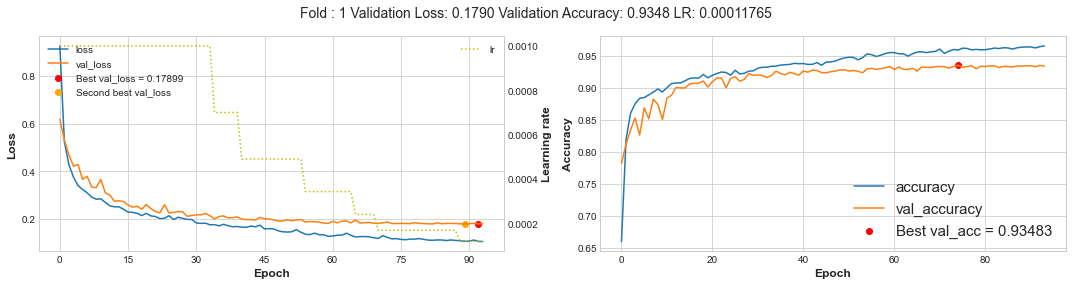

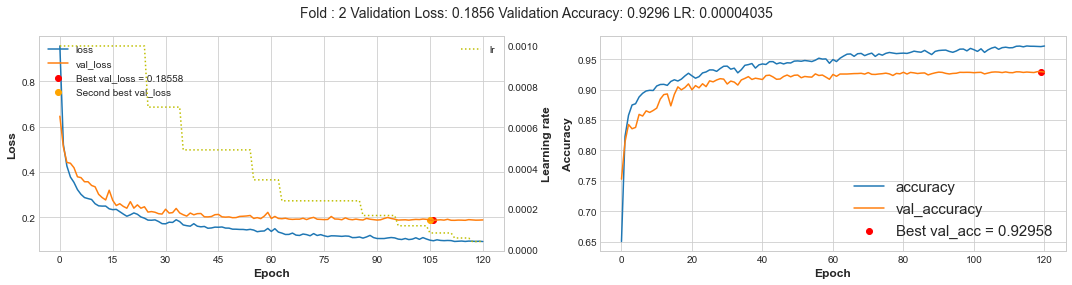

In [49]:
def plot_acc(f_scores):
    for fold in range(f_scores['folds'].nunique()):
        history_f = f_scores[f_scores['folds'] == fold]

        best_epoch = np.argmin(np.array(history_f['val_loss']))
        best_val_loss = history_f['val_loss'][best_epoch]

        fig, ax1 = plt.subplots(1, 2, tight_layout=True, figsize=(15,4))

        fig.suptitle('Fold : '+ str(fold+1) +
                     " Validation Loss: {:0.4f}".format(history_f['val_loss'].min()) +
                     " Validation Accuracy: {:0.4f}".format(history_f[ACC_VAL_METRICS].max()) +
                     " LR: {:0.8f}".format(history_f['lr'].min())
                     , fontsize=14)

        plt.subplot(1,2,1)
        plt.plot(history_f.loc[:, ['loss', 'val_loss']], label= ['loss', 'val_loss'])
                
        from_epoch = 0
        if best_epoch >= from_epoch:
            plt.scatter([best_epoch], [best_val_loss], c = 'r', label = f'Best val_loss = {best_val_loss:.5f}')
        if best_epoch > 0:
            almost_epoch = np.argmin(np.array(history_f['val_loss'])[:best_epoch])
            almost_val_loss = history_f['val_loss'][almost_epoch]
            if almost_epoch >= from_epoch:
                plt.scatter([almost_epoch], [almost_val_loss], c='orange', label = 'Second best val_loss')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='upper left')   
        
        ax2 = plt.gca().twinx()
        ax2.plot(history_f.loc[:, ['lr']], 'y:', label='lr' ) # default color is same as first ax
        ax2.set_ylabel('Learning rate')
        ax2.legend(loc = 'upper right')
        ax2.grid()

        best_epoch = np.argmax(np.array(history_f[ACC_VAL_METRICS]))
        best_val_acc = history_f[ACC_VAL_METRICS][best_epoch]
        
        plt.subplot(1,2,2)
        plt.plot(history_f.loc[:, [ACC_METRICS, ACC_VAL_METRICS]],label= [ACC_METRICS, ACC_VAL_METRICS])
        if best_epoch >= from_epoch:
            plt.scatter([best_epoch], [best_val_acc], c = 'r', label = f'Best val_acc = {best_val_acc:.5f}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc = 'lower left')
        plt.legend(fontsize = 15)
        plt.grid(b = True, linestyle = '-')

plot_acc(f_scores)

But instead of just looking at the mean accuracy across the 10 cross-validation folds, let's plot all 10 scores for each model, along with a box plot highlighting the lower and upper quartiles, and "whiskers" showing the extent of the scores. Note that the `boxplot()` function detects outliers (called "fliers") and does not include them within the whiskers. Specifically, if the lower quartile is $Q_1$ and the upper quartile is $Q_3$, then the interquartile range $IQR = Q_3 - Q_1$ (this is the box's height), and any score lower than $Q_1 - 1.5 \times IQR$ is a flier, and so is any score greater than $Q3 + 1.5 \times IQR$.

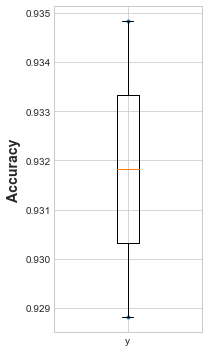

In [50]:
plt.figure(figsize = (3, 5))
plt.plot([1]*FOLDS, total_acc, ".")
plt.boxplot([total_acc], labels = ("y"))
plt.ylabel("Accuracy", fontsize = 14)
plt.show()

## Confusion matrix

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$



In [51]:
def plot_cm(cm):
    metrics = {
        'accuracy': cm / cm.sum(),
        'recall' : cm / cm.sum(axis =1 ),
        'precision': cm / cm.sum(axis = 0)
    }
    
    fig, ax = plt.subplots(1,3, tight_layout = True, figsize = (15,5))
    ax = ax.flatten()

#     mask = (np.eye(cm.shape[0]) == 0) * 1

    for idx, (name, matrix) in enumerate(metrics.items()):

        ax[idx].set_title(name)

        sns.heatmap(
            data = matrix,
            cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True),
            cbar = False,
#             mask=mask,
            lw = 0.25,
            annot = True,
            fmt = '.2f',
            ax = ax[idx]
        )
    sns.despine()

In [52]:
oof_y_hat = []
for key, value in sorted(preds_valid_f.items()):
    oof_y_hat.append(value)

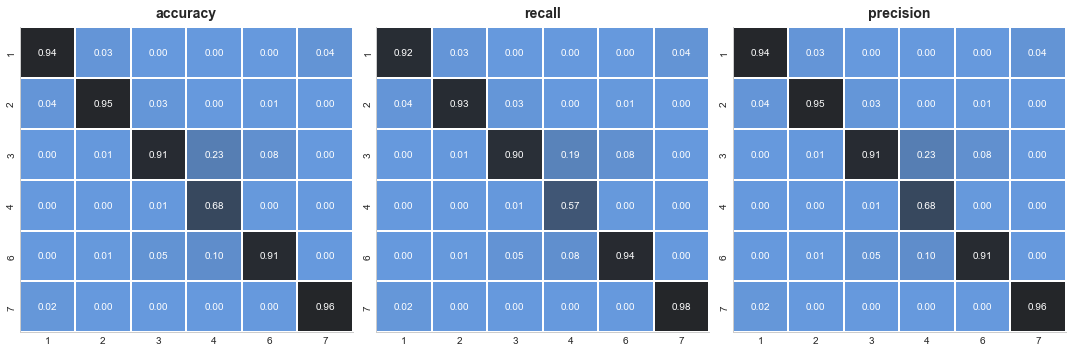

In [53]:
# create confusion matrix, calculate accuracy,recall & precision
cm = pd.DataFrame(data = confusion_matrix(y, oof_y_hat, labels = le.classes_), index = le.classes_, columns = le.classes_)
plot_cm(cm)

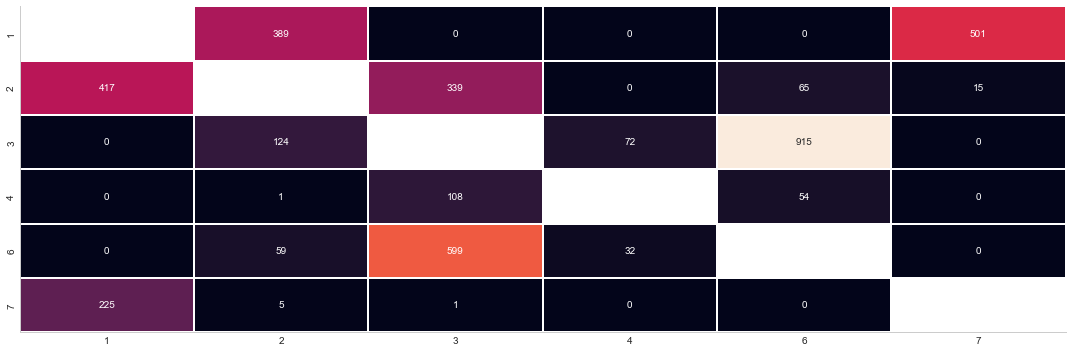

In [54]:
def plot_cm_error(cm):
    mask = (np.eye(cm.shape[0]) != 0) * 1
    fig, ax = plt.subplots(tight_layout=True, figsize=(15,5))
    sns.heatmap(
                data = pd.DataFrame(data=cm, index=le.classes_, columns = le.classes_),
    #             cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True),
                cbar = False,
                lw = 0.25,
                mask = mask,
                annot = True,
                fmt = '.0f',
                ax = ax
            )
    sns.despine()
    
plot_cm_error(confusion_matrix(y, oof_y_hat, labels = le.classes_))

In [55]:
preds_test.shape

(1000000, 6)

# Submission

In [56]:
sub = pd.read_csv(INPUT + '/sample_submission.csv')
sub[column_y] = le.inverse_transform(np.argmax(preds_test, axis=1)) # (stats.mode(preds_test)[0][0]) preds_test[FOLDS-1] # argmax reverse of to_categorical sub[column_y] = (np.argmax(sum(preds_test), axis=1) + 1) # le.inverse_transform(np.argmax(preds_test, axis=1))
sub.to_csv('submission.csv', index=False)
sub

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
...,...,...
999995,4999995,2
999996,4999996,1
999997,4999997,2
999998,4999998,1


In [57]:
np.unique(sub[column_y], return_counts=True)

(array([1, 2, 3, 4, 6, 7], dtype=int8),
 array([374962, 488281,  81210,    856,  19839,  34852], dtype=int64))

In [58]:
np.unique(y_cat, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([11426, 11426, 11426,   379, 11426, 11426], dtype=int64))

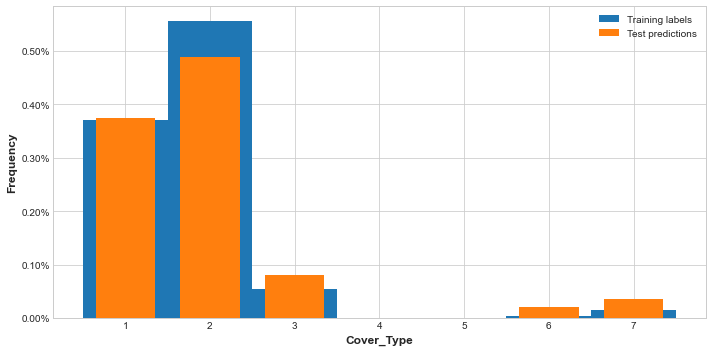

In [59]:
# Plot the distribution of the test predictions vs training set
plt.figure(figsize=(10,5))
plt.hist(train_data[column_y], bins = np.linspace(0.5, 7.5, 8), density = True, label = 'Training labels')
plt.hist(sub[column_y], bins = np.linspace(0.5, 7.5, 8), density = True, rwidth = 0.7, label = 'Test predictions')
plt.xlabel(column_y)
plt.ylabel('Frequency')
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.show()


C:\Users\furyx\AppData\Local\Temp/ipykernel_22960/3041114478.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


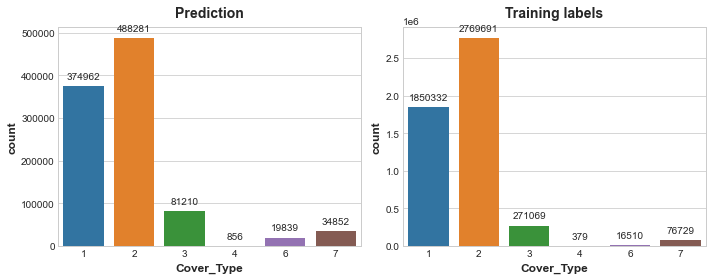

In [60]:
def plot_x_labels(ax):
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                    xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

# Plot the distribution of the test predictions
fig, ax = plt.subplots(1,2,figsize = (10,4))
sns.countplot(x = sub[column_y], ax = ax[0], orient = "h").set_title("Prediction")
plot_x_labels(ax[0])
# Plot the distribution of the training set
sns.countplot(x = train_data[column_y], ax = ax[1], orient = "h").set_title("Training labels")
plot_x_labels(ax[1])
fig.show()

To submit these predictions to the competition, follow these steps:

1. Begin by clicking on the blue **Save Version** button in the top right corner of the window.  This will generate a pop-up window.
2. Ensure that the **Save and Run All** option is selected, and then click on the blue **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Output** tab on the right of the screen.  Then, click on the file you would like to submit, and click on the blue **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

# Next Steps #

If you want to keep working to improve your performance, select the blue **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.

Be sure to check out [other users' notebooks](https://www.kaggle.com/c/tabular-playground-series-dec-2021/code) in this competition. You'll find lots of great ideas for new features and as well as other ways to discover more things about the dataset or make better predictions. There's also the [discussion forum](https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion), where you can share ideas with other Kagglers.

Have fun Kaggling!

## Op-level graph

Start TensorBoard and wait a few seconds for the UI to load. Select the Graphs dashboard by tapping “Graphs” at the top. 

In [61]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard
# %tensorboard --logdir logs

In [62]:
# %reload_ext tensorboard

In [63]:
from xgboost import XGBClassifier
#gpu_hist gpu_predictor cpu_predictor
xgb_params = {
    'objective': 'multi:softmax',
    'tree_method': 'hist', 
    'use_label_encoder': False,
    'seed': RANDOM_STATE, 
    'eval_metric': ['mlogloss', 'merror'],
    'predictor': 'cpu_predictor'
}

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# %%time
# y_train, y_valid = y_cat[train_index], y_cat[valid_index]
# xgb_model = XGBClassifier(**xgb_params)
# xgb_history = xgb_model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], verbose = VERBOSE)

# preds_train = xgb_model.predict(X_train)
# preds_valid = xgb_model.predict(X_valid)
# acc_train = accuracy_score(y_train, preds_train)
# acc = accuracy_score(y_valid, preds_valid)
# print(f"train: {acc_train:.6f}, valid: {acc:.6f}")

# preds_test = xgb_model.predict(X_test)

In [ ]:
# preds_valid.shape

In [ ]:
# create confusion matrix, calculate accuracy,recall & precision
# cm = pd.DataFrame(data=confusion_matrix(y_valid, preds_valid, labels=le.classes_), index=le.classes_, columns=le.classes_)
# plot_cm(cm)

In [ ]:
# plot_cm_error(cm)